# Matrix Multiplication using CUDA

### Submitted by Ashwin S Shenoy (AM.EN.U4CSE18109)

## System Specification & Setup

I did have a Nvidia MX150 in my laptop, but it seemed I needded to install too many drivers to run cuda programs nvcc (>2GB). Yet I tried it with Windows as well as the WSL version, but both didnt work our properly - was giving me segmentation fault etc.

Then I knew that Google Colab offered Nvidia GPUs which we could use a Jupyter Notebook (which is essentially python), and then on googling about it, I found we can actually install a plugin and execute CUDA programs on Colab (Cloud Computing!).

Thanks to Colab, I was able to learn, write, run and debug the code all at one place.

In [2]:
!nvidia-smi

Mon May 31 19:48:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Google gave me a shared instance of Nvidia Tesla T4 GPU - which has 6.63 TFLOPS higher performance than my MX150 (7.76 TFLOPS vs 1.127 TFLOPS).

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [4]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-2m1lmjfq
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-2m1lmjfq
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp37-none-any.whl size=4307 sha256=b98affaaab85fadc0beca1892d219d617d6318e6b04d62af922a2d754c9f9e91
  Stored in directory: /tmp/pip-ephem-wheel-cache-23kwx2lo/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin


In [5]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


# CUDA Blocks & Threads

![image.png](https://developer-blogs.nvidia.com/wp-content/uploads/2020/06/gpus-in-blocks-625x203.png)
![](https://developer-blogs.nvidia.com/wp-content/uploads/2020/06/kernel-execution-on-gpu-1-625x438.png)

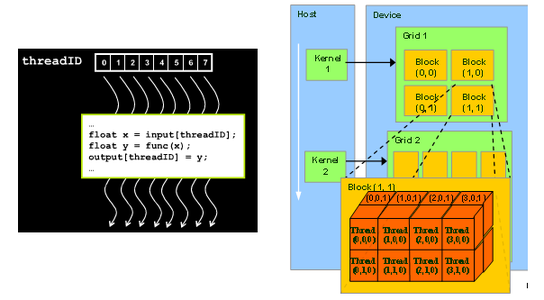


## How it Works?
1. The matrices to be multiplied, and the resultant matrix are stored in the global memory of the grids, and thus can be accessed by all the devices (GPU threads), after being copied from the host (CPU) memory.
2. Each element of the resultant matrix is computed by a dedicated GPU thread
3. A thread traverses 1 row of matrix A and 1 column of matrix B
4. Each thread having multiplied each of the corresponding row element of A with column element of B, using a temporary variable sums them up.
5. The sum is written to the assigned element in the resultant matrix
6. The resultant matrix is also copied back to host memory, after the computation.

In [6]:
%%cu
#include <stdio.h>
#include <stdlib.h>

#define BLOCK_SIZE 16  // threads per block

void multiply_using_cpu(int *m1, int *m2, int *rcpu, int m, int n, int k) {
    for (int row = 0; row < m; row++) 
        for (int col = 0; col < k; col++) 
        {
            int sum = 0;
            for (int i = 0; i < n; i++) 
                sum += m1[row * n + i] * m2[i * k + col];
            rcpu[row * k + col] = sum;
        }
}

__global__ void multiply_using_gpu(int *m1, int *m2, int *rgpu, int m, int n, int k)
{ 
    // We no longer need to run 2 for loops over row & col, but rather
    // we directly find the row & column assigned to the thread in the resultant matrix - 
    // as each thread is assigned to a specific element.
    int row = blockIdx.y * blockDim.y + threadIdx.y; 
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    // Each thread in one specific block is identified by threadIdx.x and threadIdx.y. 
    // Each block is one specific grid is identified by blockIdx.x and blockIdx.y. 
    // Therefore, if we have threadIdx.x, threadIdx.y, blockIdx.x and blockIdx.y, we can locate one specific thread.

    // Boundary protection - as there is chance of block having more threads than required
    // There is no problem if k & m are multiples of BLOCK_SIZE, but otherwise there is.
    if(col < k && row < m) 
    {
      int sum = 0;
      for(int i = 0; i < n; i++)
          // summing up & accumulating result for a single cell in resultant matrix  
          sum += m1[row * n + i] * m2[i * k + col];
      // write the result
      rgpu[row * k + col] = sum;
    }
}

void initialize_matrix(int *matrix, int m, int n) {
    //  We linearize the matrices to a 2D array and 
    //  stack each row lengthways, from the first to the last.  (Row Major Ordering)
    for (int row = 0; row < m; row++)
        for (int col = 0; col < n; col++)
            matrix[row * n + col] = rand();  
}

int check_for_discrepancies(int *r1, int *r2, int m, int n, int k) {
    int isValidated = 1;
    for (int i = 0; i < m; i++)
        for (int j = 0; j < k; j++)
            if(r1[i*k + j] != r2[i*k + j])
                isValidated = 0;
    return isValidated;
}

float test_case(int m, int n, int k) {
    printf("Multiplying a %d x %d matrix with %d x %d matrix \n", m, n, n, k);
    printf("---------------------\n\n");
    
    // allocate memory space for matrices & results on the host
    int *m1, *m2, *rcpu, *rgpu;
    cudaMallocHost((void **) &m1, sizeof(int)*m*n);  // Efficient way of writing - int *m1 = (int*)malloc(sizeof(int)*m*n); 
    cudaMallocHost((void **) &m2, sizeof(int)*n*k);
    cudaMallocHost((void **) &rcpu, sizeof(int)*m*k);
    cudaMallocHost((void **) &rgpu, sizeof(int)*m*k);

    initialize_matrix(m1, m, n);
    initialize_matrix(m2, n, k);

    float gpu_time_ms, cpu_time_ms;

    // some events to count the execution time
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
 
    // start the CPU version
    cudaEventRecord(start, 0);

    multiply_using_cpu(m1, m2, rcpu, m, n, k);

    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&cpu_time_ms, start, stop);
    printf("CPU: %f ms.\n", cpu_time_ms);

    // start to count execution time of GPU version
    cudaEventRecord(start, 0);
 
    // Allocate memory space on the device 
    int *dm1, *dm2, *dr;
    cudaMalloc((void **) &dm1, sizeof(int)*m*n);
    cudaMalloc((void **) &dm2, sizeof(int)*n*k);
    cudaMalloc((void **) &dr, sizeof(int)*m*k);

    // copy matrix A and B from host to device memory
    cudaMemcpy(dm1, m1, sizeof(int)*m*n, cudaMemcpyHostToDevice);
    cudaMemcpy(dm2, m2, sizeof(int)*n*k, cudaMemcpyHostToDevice);

    // We arrange the thread-blocks and grid in 2-D as we want to multiply a 2D matrix
    unsigned int grid_rows = (m + BLOCK_SIZE - 1) / BLOCK_SIZE;
    unsigned int grid_cols = (k + BLOCK_SIZE - 1) / BLOCK_SIZE;
    dim3 grid(grid_cols, grid_rows);
    dim3 threads(BLOCK_SIZE, BLOCK_SIZE);

    // The function is a CUDA kernel, and is executed by an array of CUDA threads. All threads run the same code. 
    multiply_using_gpu<<<grid,threads>>>(dm1, dm2, dr, m, n, k);    

    // Copy back the results from the device to host
    cudaMemcpy(rgpu, dr, sizeof(int)*m*k, cudaMemcpyDeviceToHost);
 
    cudaThreadSynchronize();
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&gpu_time_ms, start, stop);
    printf("GPU: %f ms.\n", gpu_time_ms);

    // Freeup device memory
    cudaFree(dm1);
    cudaFree(dm2);
    cudaFree(dr);
 
    printf("\n");
 
    // Check for discrepencies & compute & show speedUp
    if(check_for_discrepancies(rcpu, rgpu, m, n, k))
        printf("Speedup = %f \n\n\n", cpu_time_ms / gpu_time_ms);
    else
        printf("Results from CPU & GPU are not matching. \n\n\n");


    // Freeup host memory
    cudaFreeHost(m1);
    cudaFreeHost(m2);
    cudaFreeHost(rcpu);
    cudaFreeHost(rgpu);

    return cpu_time_ms / gpu_time_ms;  // return speedup
}

int main()
{
    float s0, s1, s2, s3, s4;
    s0 = test_case(128, 64, 128);
    s1 = test_case(256, 128, 256);
    s2 = test_case(512, 256, 512);
    s3 = test_case(1024, 512, 1024);
    s4 = test_case(2048, 1024, 2048);
   
    printf("Summary of SpeedUps\n");
    printf("---------------------\n");
    printf("128 x 64 Matrix = %f\n", s0);
    printf("256 x 128 Matrix = %f\n", s1);
    printf("512 x 256 Matrix = %f\n", s2);
    printf("1024 x 512 Matrix = %f\n", s3);
    printf("2048 x 1024 Matrix = %f\n", s4);
 
    return 0;
}

Multiplying a 128 x 64 matrix with 64 x 128 matrix 
---------------------

CPU: 3.013952 ms.
GPU: 0.264864 ms.

Speedup = 11.379244 


Multiplying a 256 x 128 matrix with 128 x 256 matrix 
---------------------

CPU: 25.935553 ms.
GPU: 0.312128 ms.

Speedup = 83.092682 


Multiplying a 512 x 256 matrix with 256 x 512 matrix 
---------------------

CPU: 235.678207 ms.
GPU: 1.013664 ms.

Speedup = 232.501312 


Multiplying a 1024 x 512 matrix with 512 x 1024 matrix 
---------------------

CPU: 3503.583008 ms.
GPU: 5.575104 ms.

Speedup = 628.433655 


Multiplying a 2048 x 1024 matrix with 1024 x 2048 matrix 
---------------------

CPU: 27842.218750 ms.
GPU: 38.998592 ms.

Speedup = 713.928833 


Summary of SpeedUps
---------------------
128 x 64 Matrix = 11.379244
256 x 128 Matrix = 83.092682
512 x 256 Matrix = 232.501312
1024 x 512 Matrix = 628.433655
2048 x 1024 Matrix = 713.928833



These speedups can be further improved by different other methods like using a faster Shared Memory (block wide) implementation instead of Global Memory (Grid wide scope) implementation like now. But currently, I have sticked on and implemented only this naive method which still performs significantly better than CPU.

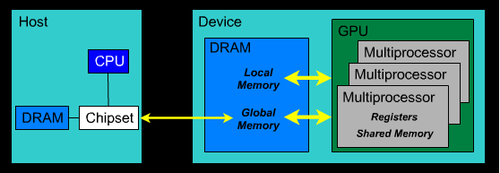

Though >90% of the code was written by me, I do acknowledge referring to multiple other implementation and learning from them. I also further acknowledge, I might not be knowing in depth about each line of the code, some CUDA functions and its significance, though I have tried my best to understand them as much as possible.

## References
- https://www.es.ele.tue.nl/~mwijtvliet/5KK73/?page=mmcuda
- http://selkie.macalester.edu/csinparallel/modules/GPUProgramming/build/html/CUDA2D/CUDA2D.html
- https://www.quantstart.com/articles/Matrix-Matrix-Multiplication-on-the-GPU-with-Nvidia-CUDA/
- https://www.youtube.com/watch?v=DpEgZe2bbU0

---- **OM NAMAH SHIVAYA** ---